## Setup

In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
import pandas as pd

from plots.plotting_functions import *

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


In [22]:
decision_model_ids = [
    "Llama-3.1-Tulu-3-70B-SFT",
    "Llama-3.1-Tulu-3-70B-DPO",
    "Llama-3.1-Tulu-3-70B",

    "OLMo-2-0325-32B-SFT",
    "OLMo-2-0325-32B-DPO",
    "OLMo-2-0325-32B-Instruct",

    "OLMo-2-1124-13B-SFT",
    "OLMo-2-1124-13B-DPO",
    "OLMo-2-1124-13B-Instruct",
]
RESULTS_DIR = "data/20250422/all_models/"


## Plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


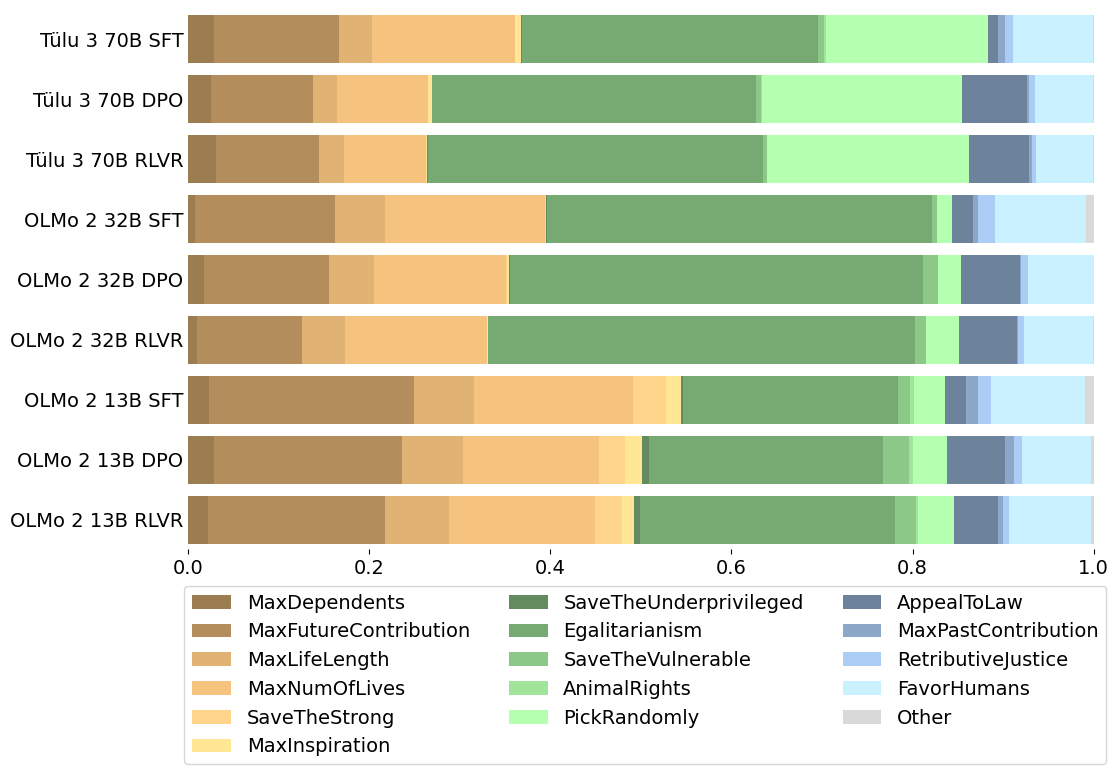

In [ ]:
%load_ext autoreload
%autoreload 2
from plots.plotting_functions import *

file_paths = [fp for fp in glob(f"{RESULTS_DIR}/judge/*.csv")]
file_paths = [fp for fp in file_paths if any(model_id in fp for model_id in decision_model_ids)]
file_paths.sort(key=lambda x: next((i for i, model_id in enumerate(decision_model_ids) if model_id in x), len(decision_model_ids)))

df_rationales = create_stacked_rationales_barchart(
    file_paths,
    figsize=(11.5, 8),
    # save_dir=f'{FIGURE_SAVE_DIR}/MLR-post_training_method.pdf',
    # first_reason_only=True,
    # sort_consequentialist=True,
    skip_refusals=True,
    normalize_by_count=False,
    normalize_by_phenomenon=True,
    return_dataframe=False,
    legend_cols=3,
)

In [132]:
%load_ext autoreload
%autoreload 2
from plots.plotting_functions import *

file_paths = [fp for fp in glob(f"{RESULTS_DIR}/judge/*.csv")]
file_paths = [fp for fp in file_paths if any(model_id in fp for model_id in decision_model_ids)]
file_paths.sort(key=lambda x: next((i for i, model_id in enumerate(decision_model_ids) if model_id in x), len(decision_model_ids)))

# Use the function to process file paths and get model quality dataframe
model_quality_df = get_model_quality_df(file_paths)
model_quality_df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,model_id,model_name,consistency,logic,bias,pluralism,acceptability,avg_quality,avg_quality_sans_pluralism
0,Llama-3.1-Tulu-3-70B-SFT,Tülu 3 70B SFT,0.437999,0.802030,0.063089,0.335025,0.936911,0.627991,0.725647
1,Llama-3.1-Tulu-3-70B-DPO,Tülu 3 70B DPO,0.355072,0.909420,0.027536,0.671014,0.972464,0.726993,0.745652
2,Llama-3.1-Tulu-3-70B,Tülu 3 70B RLVR,0.355072,0.894928,0.028986,0.681159,0.971014,0.725543,0.740338
3,OLMo-2-0325-32B-SFT,OLMo 2 32B SFT,0.317647,0.625735,0.091176,0.174265,0.908824,0.506618,0.617402
4,OLMo-2-0325-32B-DPO,OLMo 2 32B DPO,0.275436,0.664244,0.043605,0.404797,0.956395,0.575218,0.632025
5,OLMo-2-0325-32B-Instruct,OLMo 2 32B RLVR,0.252899,0.659420,0.037681,0.281884,0.962319,0.539130,0.624879
6,OLMo-2-1124-13B-SFT,OLMo 2 13B SFT,0.498549,0.518142,0.220610,0.355588,0.779390,0.537917,0.598694
7,OLMo-2-1124-13B-DPO,OLMo 2 13B DPO,0.524745,0.679039,0.150655,0.526201,0.849345,0.644833,0.684377
8,OLMo-2-1124-13B-Instruct,OLMo 2 13B RLVR,0.517417,0.720610,0.129173,0.462990,0.870827,0.642961,0.702951


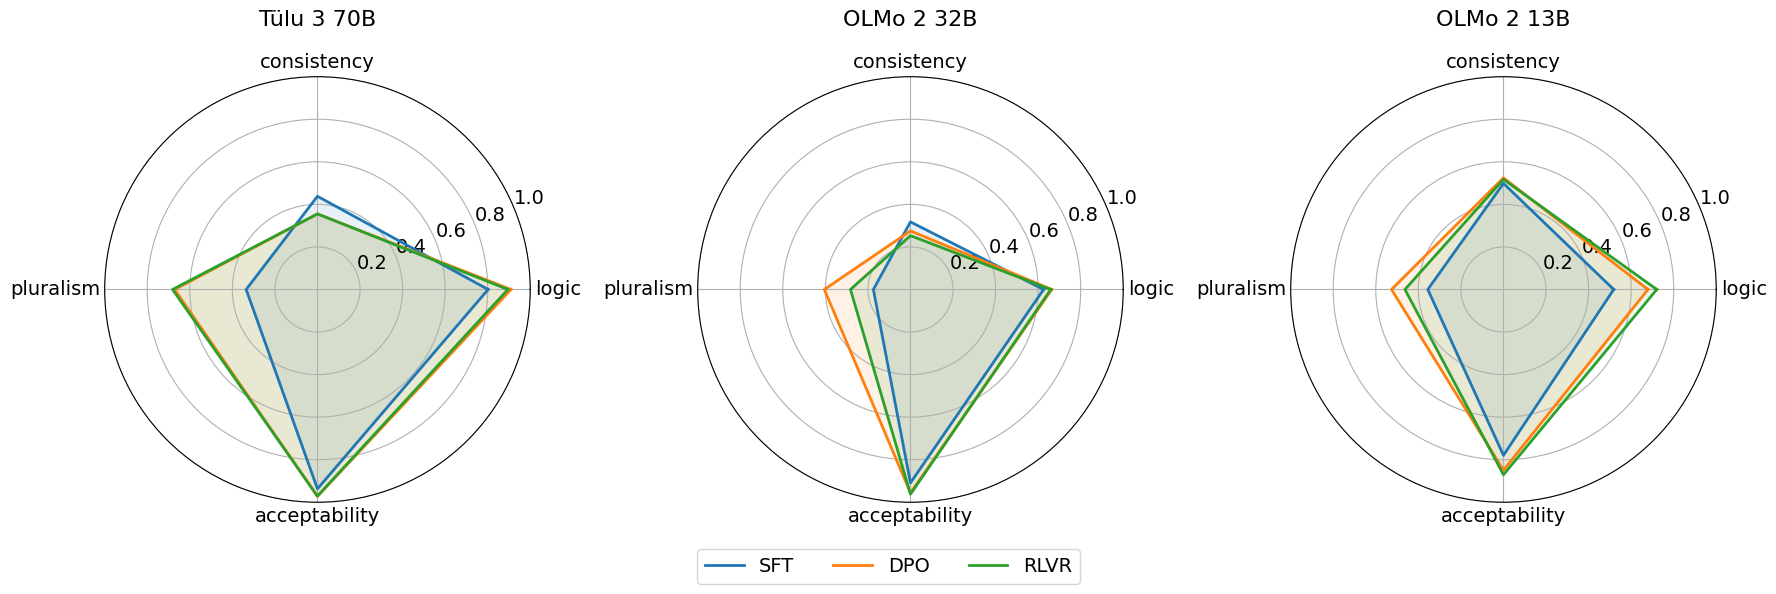

In [ ]:
def plot_model_radar(model_quality_df, groups, figsize=(18,6), save_dir=None):
    # Define the metrics we want to display
    metrics = ['logic', 'consistency', 'pluralism', 'acceptability']

    # Setup the radar plot
    fig, axes = plt.subplots(1, len(groups), subplot_kw={'projection': 'polar'}, figsize=figsize)

    # Angles for each metric
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Extract model data in a more structured way
    data = {}
    for metric in metrics:
        data[metric] = {}
        for _, row in model_quality_df.iterrows():
            data[metric][row['model_id']] = row[metric]

    # Replace 'acceptability' with 'bias' if needed (data structure seems to use bias)
    # if 'acceptability' in metrics and all(metric != 'acceptability' for metric in model_quality_df.columns):
    #     metrics[metrics.index('acceptability')] = 'bias'
    #     data['bias'] = data.pop('acceptability')

    # Plot each group
    for i, (group_name, model_ids) in enumerate(groups.items()):
        ax = axes[i] if len(groups) > 1 else axes

        for model_id in model_ids:
            # Find the corresponding row in model_quality_df
            model_row = model_quality_df[model_quality_df['model_id'] == model_id]
            if model_row.empty:
                continue

            # Extract values for each metric
            values = []
            for metric in metrics:
                values.append(model_row[metric].values[0])

            values += values[:1]  # Repeat the first value to close the radar chart

            # Get the training method (SFT, DPO, or RLVR/Instruct)
            model_type = model_id.split('-')[-1] if '-' in model_id else ''
            if model_type == 'Instruct':
                model_type = 'RLVR'
            if model_type not in ['SFT', 'DPO', 'RLVR']:
                model_type = model_row['model_name'].values[0].split()[-1]

            ax.plot(angles, values, label=model_type, linewidth=2)
            ax.fill(angles, values, alpha=0.1)

        ax.set_title(group_name, size=16, y=1.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)

        # Adjust label positions for better readability
        for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
            # Determine text alignment based on position in circle
            ha = 'right' if np.cos(angle) < -0.1 else 'left' if np.cos(angle) > 0.1 else 'center'
            va = 'top' if np.sin(angle) < -0.1 else 'bottom' if np.sin(angle) > 0.1 else 'center'

            # Set label position with improved alignment
            label_distance = 0.03  # Increase to push labels further out
            label.set_position((angle, 0.1-label_distance))
            label.set_ha(ha)
            label.set_va(va)

        ax.set_ylim(0, 1)
        ax.grid(True)

    # Create a common legend
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)

    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()


# Example usage:
plot_model_radar(
    model_quality_df,
    groups = {
        'Tülu 3 70B': [id for id in decision_model_ids if 'Tulu-3-70B' in id],
        'OLMo 2 32B': [id for id in decision_model_ids if 'OLMo-2-0325' in id],
        'OLMo 2 13B': [id for id in decision_model_ids if 'OLMo-2-1124' in id],
    },
    # save_dir=f"{FIGURE_SAVE_DIR}/MLQ-post_training_radars.pdf"
)


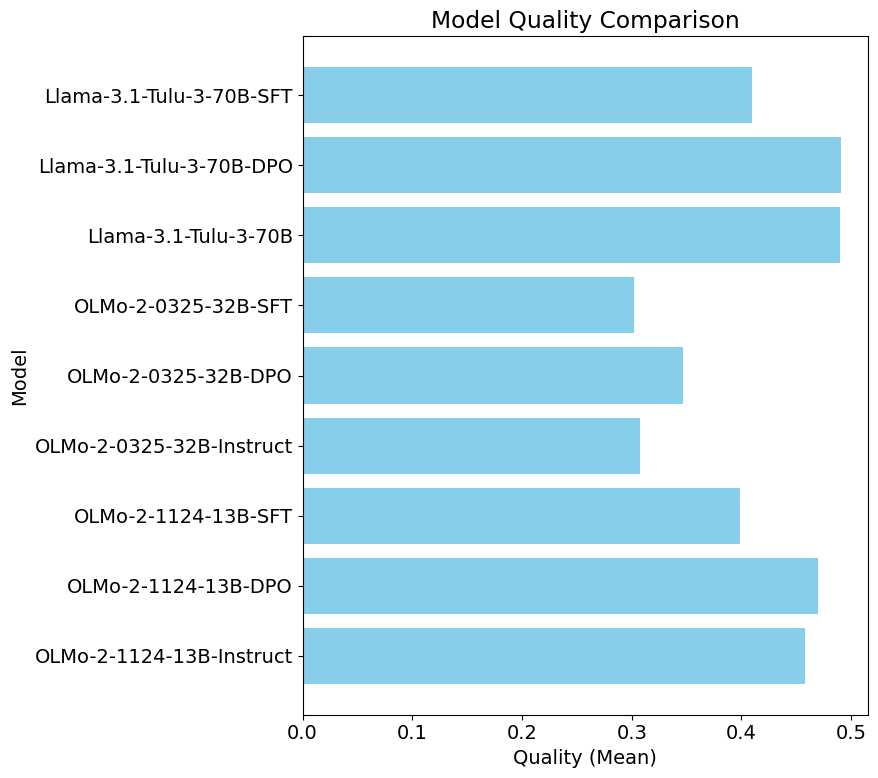

In [96]:
# Plot model_quality_df using matplotlib
plt.figure(figsize=(9, 8))
plt.barh(model_quality_df.iloc[::-1].index, model_quality_df.iloc[::-1]['avg_quality'], color='skyblue')
plt.xlabel("Quality (Mean)")
plt.ylabel("Model")
plt.title("Model Quality Comparison")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
random.seed(42)  # For reproducibility

# Create a list of model names
model_names = [
    "GPT-4o", "GPT-4o mini", "GPT-3.5 Turbo", "o1-mini",
    "Claude 3 Haiku", "Claude 3.5 Haiku", "Claude 3.5 Sonnet",
    "Gemini 1.5 Flash", "Gemini 1.5 Flash 8B", "Gemini 2 Flash", "Gemini 2 Flash Lite",
    "Llama 3.1 8B", "Llama 3.3 70B", "Llama 4 Scout", "Llama 4 Maverick",
    "Phi-4", "Gemma 3 4B", "Gemma 3 12B", "Gemma 3 27B",
    "Qwen 2.5 7B", "Qwen 2.5 72B", "Qwen Turbo", "Qwen Max", "Qwen Plus",
    "OLMo 2 7B SFT", "OLMo 2 7B DPO", "OLMo 2 7B RLVR",
    "OLMo 2 13B SFT", "OLMo 2 13B DPO", "OLMo 2 13B RLVR",
    "OLMo 2 32B SFT", "OLMo 2 32B DPO", "OLMo 2 32B RLVR",
    "DeepSeek V3", "DeepSeek R1"
]

# Define model metadata
model_metadata = {}
for model in model_names:
    # Determine parameter count
    if "mini" in model.lower() or "3.5" in model or "3B" in model or "4B" in model or "7B" in model or "8B" in model:
        param_count = random.choice([3e9, 4e9, 7e9, 8e9, 13e9])
    elif "12B" in model or "13B" in model:
        param_count = random.choice([12e9, 13e9])
    elif "27B" in model or "32B" in model:
        param_count = random.choice([27e9, 32e9])
    elif "70B" in model or "72B" in model:
        param_count = random.choice([70e9, 72e9])
    else:
        param_count = random.choice([13e9, 70e9, 175e9])

    # Determine if it's a reasoning model
    is_reasoning_model = any(x in model for x in ["R1", "o1", "o3", "thinking", "Reasoning", "Scout"])

    # Determine if it's RLHF or similar
    is_rlhf = any(x in model for x in ["RLHF", "RLVR", "DPO"]) or (not "SFT" in model and random.random() > 0.5)

    # Assign GSM8K score (correlation with parameter count and reasoning capability)
    gsm8k_base = 0.65 + 0.2 * (np.log(param_count) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    gsm8k_reasoning_bonus = 0.1 if is_reasoning_model else 0
    gsm8k_score = min(0.98, max(0.65, gsm8k_base + gsm8k_reasoning_bonus + random.uniform(-0.05, 0.05)))

    # Assign BBQ (bias) score
    bbq_base = 0.7 + 0.1 * (np.log(param_count) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    bbq_rlhf_bonus = 0.08 if is_rlhf else 0
    bbq_score = min(0.95, max(0.65, bbq_base + bbq_rlhf_bonus + random.uniform(-0.07, 0.07)))

    model_metadata[model] = {
        "parameter_count": param_count,
        "is_reasoning_model": is_reasoning_model,
        "is_rlhf": is_rlhf,
        "gsm8k_score": gsm8k_score,
        "bbq_score": bbq_score
    }

# Generate data for each model, with 3 samples per model
data = []
for model in model_names:
    meta = model_metadata[model]

    # Create parameter category
    if meta["parameter_count"] < 10e9:
        param_category = "small"
    elif meta["parameter_count"] < 30e9:
        param_category = "medium"
    elif meta["parameter_count"] < 100e9:
        param_category = "large"
    else:
        param_category = "xlarge"

    # Base moral reasoning patterns (influenced by model characteristics)
    # Smaller models tend to be more consequentialist, bigger ones more deontological
    consequentialism_base = 0.6 - 0.25 * (np.log(meta["parameter_count"]) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    consequentialism_base = max(0.2, min(0.6, consequentialism_base))

    deontology_base = 0.3 + 0.25 * (np.log(meta["parameter_count"]) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    deontology_base = max(0.3, min(0.65, deontology_base))

    contractualism_base = 1 - consequentialism_base - deontology_base

    # Reasoning models tend to be better at coherence
    logic_quality_base = 0.65 + 0.15 * (np.log(meta["parameter_count"]) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    logic_quality_base += 0.1 if meta["is_reasoning_model"] else 0
    logic_quality_base = min(0.95, max(0.65, logic_quality_base))

    # RLHF models tend to have better acceptability scores
    acceptability_base = 0.7 + 0.1 * (np.log(meta["parameter_count"]) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    acceptability_base += 0.12 if meta["is_rlhf"] else 0
    acceptability_base = min(0.95, max(0.7, acceptability_base))

    # Pluralism increases with model size and RLHF
    pluralism_base = 0.6 + 0.2 * (np.log(meta["parameter_count"]) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
    pluralism_base += 0.08 if meta["is_rlhf"] else 0
    pluralism_base = min(0.9, max(0.6, pluralism_base))

    # Generate 3 samples per model with some variance
    for sample_id in range(1, 4):
        consequentialism = max(0, min(1, consequentialism_base + random.uniform(-0.05, 0.05)))
        deontology = max(0, min(1, deontology_base + random.uniform(-0.05, 0.05)))

        # Adjust to make sure they add up to 100%
        sum_scores = consequentialism + deontology
        if sum_scores > 0.9:
            factor = 0.9 / sum_scores
            consequentialism *= factor
            deontology *= factor

        contractualism = 1.0 - consequentialism - deontology

        # Generate quality scores with some variance
        logic_quality = max(0, min(1, logic_quality_base + random.uniform(-0.05, 0.05)))
        acceptability = max(0, min(1, acceptability_base + random.uniform(-0.05, 0.05)))
        pluralism = max(0, min(1, pluralism_base + random.uniform(-0.05, 0.05)))

        # Calculate overall quality score
        quality_score = (logic_quality + acceptability + pluralism) / 3

        # Generate response length (correlated with model size)
        response_length_base = 500 + 500 * (np.log(meta["parameter_count"]) - np.log(3e9)) / (np.log(175e9) - np.log(3e9))
        response_length = int(max(400, min(2000, response_length_base + random.uniform(-100, 100))))

        data.append({
            "model_name": model,
            "sample_id": sample_id,
            "parameter_count": meta["parameter_count"],
            "parameter_category": param_category,
            "is_reasoning_model": meta["is_reasoning_model"],
            "is_rlhf": meta["is_rlhf"],
            "response_length": response_length,
            "gsm8k_score": meta["gsm8k_score"],
            "bbq_score": meta["bbq_score"],
            "consequentialism_score": consequentialism,
            "deontology_score": deontology,
            "contractualism_score": contractualism,
            "logic_quality": logic_quality,
            "acceptability": acceptability,
            "pluralism": pluralism,
            "quality_score": quality_score
        })

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Add the date the data was generated
print(f"Generated example data on {datetime.now().strftime('%Y-%m-%d')}")

# Show the DataFrame structure
print(f"Dataset shape: {df.shape}")
print(df.head())

# Save to CSV
df.to_csv("moral_reasoning_example_data.csv", index=False)
print("Data saved to 'moral_reasoning_example_data.csv'")

# Basic summary statistics
print("\nSummary statistics:")
print(df[["consequentialism_score", "deontology_score", "contractualism_score", "quality_score"]].describe())

# Mean values by parameter category
print("\nMean values by parameter category:")
print(df.groupby("parameter_category")[["consequentialism_score", "deontology_score", "contractualism_score", "quality_score"]].mean())

# Mean values by RLHF status
print("\nMean values by RLHF status:")
print(df.groupby("is_rlhf")[["consequentialism_score", "deontology_score", "contractualism_score", "quality_score"]].mean())

# Mean values by reasoning model status
print("\nMean values by reasoning model status:")
print(df.groupby("is_reasoning_model")[["consequentialism_score", "deontology_score", "contractualism_score", "quality_score"]].mean())

In [139]:

df = pd.read_csv("moral_reasoning_example_data.csv")

In [140]:
df

,model_name,sample_id,parameter_count,parameter_category,is_reasoning_model,is_rlhf,response_length,gsm8k_score,bbq_score,consequentialism_score,deontology_score,contractualism_score,logic_quality,acceptability,pluralism,quality_score
0,GPT-4o,1,1.750000e+11,xlarge,False,False,997,0.874155,0.764285,0.312164,0.587836,0.100000,0.842243,0.841849,0.809894,0.831329
1,GPT-4o,2,1.750000e+11,xlarge,False,False,948,0.874155,0.764285,0.311187,0.536298,0.152515,0.848532,0.830677,0.773945,0.817718
2,GPT-4o,3,1.750000e+11,xlarge,False,False,1006,0.874155,0.764285,0.356736,0.507876,0.135389,0.823191,0.831602,0.847798,0.834197
3,GPT-4o mini,1,4.000000e+09,small,False,True,556,0.681820,0.841980,0.544889,0.333663,0.121449,0.705297,0.793588,0.696917,0.731934
4,GPT-4o mini,2,4.000000e+09,small,False,True,515,0.681820,0.841980,0.571978,0.328022,0.100000,0.686139,0.846062,0.715445,0.749215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,DeepSeek V3,2,1.750000e+11,xlarge,False,True,1052,0.887052,0.851782,0.322892,0.567430,0.109678,0.836052,0.928712,0.832075,0.865613
101,DeepSeek V3,3,1.750000e+11,xlarge,False,True,988,0.887052,0.851782,0.365972,0.534028,0.100000,0.826311,0.887519,0.881896,0.865242
102,DeepSeek R1,1,1.750000e+11,xlarge,True,True,994,0.919891,0.862348,0.318093,0.581907,0.100000,0.893588,0.951424,0.926906,0.923973
103,DeepSeek R1,2,1.750000e+11,xlarge,True,True,999,0.919891,0.862348,0.340835,0.532106,0.127059,0.860460,0.886082,0.871165,0.872569


In [138]:

# Save the results table
# results_table.to_csv("hypothesis_testing_results.csv", index=False)
print("\nResults table saved to 'hypothesis_testing_results.csv'")

# Print the results table
print("\nHypothesis Testing Summary:")
results_table


Results table saved to 'hypothesis_testing_results.csv'

Hypothesis Testing Summary:


,Hypothesis,p-value,Test Statistic,Effect Size,Conclusion
0,Larger models do not perform better at moral r...,3.660106e-09,F = 29.206,η² = 0.739,Reject H₀
1,RLHF does not increase consequentialist responses,4.289519e-01,t = 0.801,d = 0.270,Fail to reject H₀
2,Instruction-tuned models are not better at mor...,3.664156e-02,t = 2.581,d = 1.450,Reject H₀
3,No relationship between math and moral reasoning,1.156392e-10,r = 0.849,r = 0.849,Reject H₀
